In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import string
import nltk
%matplotlib inline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix,r2_score


Bad key "text.kerning_factor" on line 4 in
/Users/Tanner/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
dfm = pd.read_csv('./datasets/dfm.csv')

In [3]:
dfb = pd.read_csv('./datasets/dfb.csv')

In [4]:
#combine 2 datasets
df = pd.concat((dfm,dfb), axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

In [5]:
df.shape

(8451, 3)

In [6]:
df['selftext'][6:20]

6     I've noticed in the 10 films he has directed, ...
7     Brazilian movies - like most from South Americ...
8     The 1960s were an interesting era in Hollywood...
9     Hi guys I was wondering if you’d be able to he...
10    I recently watched the Assassination of Jesse ...
11    Assume the world ends in 2070, 50 years from n...
12    The film, First Black, is a suspenseful tale t...
13    I just want to recommend Things To Do in Denve...
14    The film, First Black, is a suspenseful tale t...
15    While I love Goodfellas and find it extremely ...
16    I want to see movies like climax(2018), enter ...
17    Trailer editing is a fascinating part of the m...
18    I was thinking about this while watching *Upsi...
19    \n|*Rank*|*Title*|*Domestic Gross (Weekend)*|*...
Name: selftext, dtype: object

In [7]:
#Clean up some of the data just removing extreme values 
df = df[df['text_len'] <= 6000]

In [8]:
#Removing null values
df.dropna(inplace = True)

In [9]:
#Check shape to make sure I didn't lose to much data
df.shape

(8174, 3)

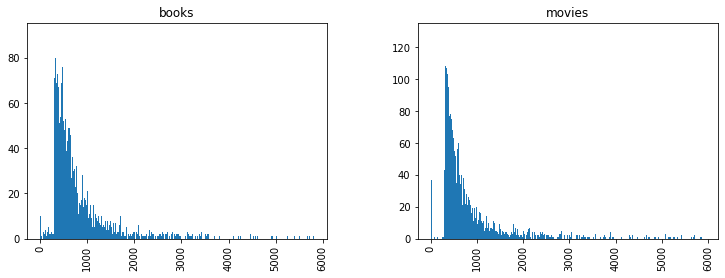

In [10]:
#graph distribution of word count based on subreddit

df.hist(column ='text_len',by= 'subreddit',bins = 600, figsize=(12,4));

In [11]:
# See that data length is very equivalent
df.groupby('subreddit')['text_len'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
books,3828.0,839.256270,722.575128,9.0,419.00,601.0,953.25,5808.0
movies,4346.0,831.446387,788.011423,9.0,402.25,565.0,906.50,5923.0


In [12]:
#Adding words to your stop_words
stopwords = nltk.corpus.stopwords.words('english')
#To get results w/o additional stopwords comment out the below lines
newStopWords = ['book','books','page','chapter','movie','movies','film','films','filmed','novel','Hollywood','camera','read','seen','saw','pages','author','authors','watch','watched','ve','reading','https','com']
stopwords.extend(newStopWords)

In [13]:
#Create graph of top words movies
dfm.dropna(inplace = True)
Xm = dfm['selftext']
cvec = CountVectorizer(stop_words=stopwords)
cvec.fit(Xm)
Xm = cvec.transform(Xm)
X_dfm = pd.DataFrame(Xm.toarray(), columns=cvec.get_feature_names())

/Users/Tanner/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['hollywood'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [14]:
top_wordsm = {}

for i in X_dfm.columns:
    top_wordsm[i] =  X_dfm[i].sum()

most_freqm = pd.DataFrame(sorted(top_wordsm.items(), key = lambda x: x[1], reverse = True))

In [15]:
most_freqm

,0,1
0,like,3746
1,one,2594
2,would,2081
3,think,2023
4,really,1907
...,...,...
28633,踊りだす今夜の4boyz,1
28634,邁進してます,1
28635,金田,1
28636,鉄夫,1


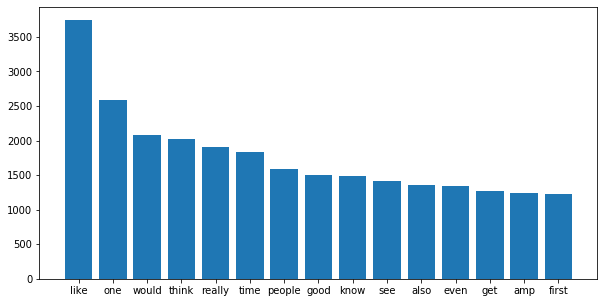

In [16]:
plt.figure(figsize = (10, 5))

plt.bar(most_freqm[0][:15], most_freqm[1][:15]);

In [17]:
#Create graph of top words books
dfb.dropna(inplace = True)
Xb = dfb['selftext']
cvec = CountVectorizer(stop_words=stopwords)
cvec.fit(Xb)
Xb = cvec.transform(Xb)
X_dfb = pd.DataFrame(Xb.toarray(), columns=cvec.get_feature_names())

/Users/Tanner/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['hollywood'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [18]:
top_wordsb = {}

for i in X_dfb.columns:
    top_wordsb[i] =  X_dfb[i].sum()

most_freqb = pd.DataFrame(sorted(top_wordsb.items(), key = lambda x: x[1], reverse = True))

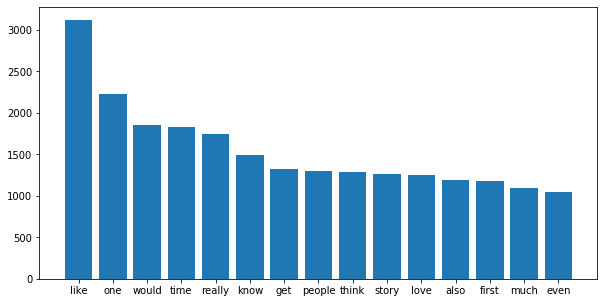

In [19]:
plt.figure(figsize = (10, 5))

plt.bar(most_freqb[0][:15], most_freqb[1][:15]);

In [20]:
most_freqb

,0,1
0,like,3120
1,one,2231
2,would,1858
3,time,1832
4,really,1741
...,...,...
26513,𝒕𝒐𝒑𝒊𝒄𝒔,1
26514,𝒘𝒂𝒚,1
26515,𝒘𝒉𝒂𝒕,1
26516,𝒘𝒉𝒚,1


In [21]:
#Create a function fro processing my data
def text_process(text):
    """
    1. Remove punctation
    2. Remove stopwords
    3. Return cleaned text
    """
    
    nopunc = ''.join([x for x in text if x not in string.punctuation])
    return [i for i in nopunc.split() if i.lower() not in stopwords]

In [22]:
#Quick preview of how this works
df['selftext'].head().apply(text_process)

0    [may, go, Jon, Voigt, Anaconda, purely, bad, a...
1    [Okay, came, HBO, MAX, thought, enjoyable, iss...
2    [Hi, Cure, Wellness, Gore, Verbinski, didnt, g...
3    [old, 1987, really, scared, first, low, budget...
4    [realize, hes, bit, unconventional, casting, c...
Name: selftext, dtype: object

In [23]:
#
X = df['selftext']
y = df['subreddit']

In [24]:
text_train, text_test, subreddit_train, subreddit_test = train_test_split(X,y, test_size=0.20, random_state=42,stratify = y)

In [25]:
text_train

1239    Remember when everybody was quoting the line "...
3166    Months ago, I went into a used bookstore and t...
2670    Me and my wife happened to come across this fi...
1481    Hello, I couldn't find a decently big subreddi...
2443    Fischer is killed by Mal moments before Saito ...
                              ...                        
3453    I've recently rewatched Matrix and it's still ...
1373    &amp;#x200B;\n\n|*Rank*|*Title*|*Domestic Gros...
2074    When I try to explain this to people I'm met w...
2305    Spoilers for both movies, but...\n\nWatching t...
2648    **Knowing:** If the Aliens knew Earth was goin...
Name: selftext, Length: 6539, dtype: object

In [26]:
#Bayes Classifier
pipeline = Pipeline([
    ('CV',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [27]:
pipeline.fit(text_train,subreddit_train)

Pipeline(memory=None,
         steps=[('CV',
                 CountVectorizer(analyzer=<function text_process at 0x7fba85795dd0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [28]:
preds = pipeline.predict(text_test)

In [31]:
print(classification_report(subreddit_test,preds))

              precision    recall  f1-score   support

       books       0.93      0.85      0.89       766
      movies       0.88      0.94      0.91       869

    accuracy                           0.90      1635
   macro avg       0.90      0.90      0.90      1635
weighted avg       0.90      0.90      0.90      1635



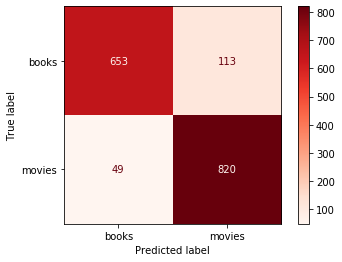

In [32]:
# View confusion matrix
plot_confusion_matrix(pipeline, text_test, subreddit_test, cmap='Reds', values_format='d');

In [49]:
#Second test with RandomForest
pipeline2 = Pipeline([
    ('CV',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])

In [50]:
pipeline2.fit(text_train,subreddit_train)

Pipeline(memory=None,
         steps=[('CV',
                 CountVectorizer(analyzer=<function text_process at 0x7fba85795dd0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b'...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.

In [51]:
preds2 = pipeline2.predict(text_test)

In [52]:
print(classification_report(subreddit_test,preds2))

              precision    recall  f1-score   support

       books       0.84      0.88      0.86       766
      movies       0.89      0.86      0.87       869

    accuracy                           0.86      1635
   macro avg       0.86      0.87      0.86      1635
weighted avg       0.87      0.86      0.86      1635



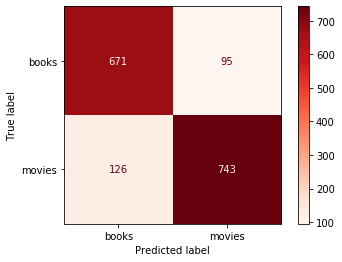

In [53]:
# View confusion matrix
plot_confusion_matrix(pipeline2, text_test, subreddit_test, cmap='Reds', values_format='d');

In [38]:
#svae new dataframe
df.to_csv('./datasets/df.csv',index=False)